# 国家信息中心CMPAS资料处理

### CMPAS中国区域地面-卫星-雷达三源融合降水分析产品 [CMPAS-V2.1](http://10.1.64.154/idata/web/data/index?dataCode=CMPAS_V2.1)

- “CMPAS中国区域地面-卫星-雷达三源融合降水分析产品（CMPAS-V2.1）”是我国高时空分辨率的多源降水融合分析产品，由CMA多源融合降水分析系统(CMPAS：CMA Multi-source merged Precipitation Analysis System)实时生成，适用于精细化气象格点预报、中小尺度极端降水事件监测、水文模型等，可为天气预报、防灾减灾等业务应用和研究提供高效高质高分辨率的降水产品。
- CMPAS-V2.1融合降水分析产品是原0.05°分辨率的“中国地面-卫星-雷达三源融合逐小时降水产品(CMPA-Hourly V2.0)”的升级版。在CMPA-Hourly V2.0原“PDF+BMA+OI”融合方法基础上，引入时空降尺度方法形成“PDF+BMA+DS+OI”的0.01°分辨率三源降水融合方案。
- 独立检验表明：0.01°分辨率的融合降水产品质量优于任一单来源降水资料的质量，虽然整体精度水平要略低于0.05°分辨率的融合降水产品，但是对强降水的把握更优，更适用于对强降水天气过程的监测。
- 作为CMPA-Hourly V2.0的升级版本，CMPAS-V2.1融合降水分析产品同时提供了0.05°和0.01°两种空间分辨率的逐小时降水产品，以满足不同用户的需求。

### 元数据基本信息
- 数据集名称：CMPAS中国区域地面-卫星-雷达三源融合降水分析产品（CMPAS-V2.1）
- 数据集代码：CMPAS-V2.1
- 更新频率：实时
- 制作时间：20161229(实时更新)
- 空间分辨率：0.05°lat/lon和0.01°lat/lon两种分辨率
- 参考系：无
- 关键词：降水融合分析产品，0.01°/逐小时、0.05°/逐小时分辨率

In [1]:
%matplotlib inline
import os
import pathlib
import shutil
import warnings
from datetime import datetime, timedelta
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from nmc_met_io.retrieve_cimiss_history import get_cmpas_hist_files
warnings.filterwarnings('ignore')

In [2]:
# set data and output directory
datadir = "/media/kan-dai/My Passport/CMPAS/DATA"
outdir_0P01 = "/media/kan-dai/CMPAS/DATA_NC/2017/0P01"
outdir_0P05 = "/media/kan-dai/CMPAS/DATA_NC/2017/0P05/"
outdir_duplicate = "/media/kan-dai/CMPAS/DATA_NC/Duplicate"

In [7]:
#----------------------------------------------------
# download the CMPAS Netcdf files from CIMISS service
#----------------------------------------------------
# set time range
time_range = "[20170101000000,20171231230000]"

# download the nc files
get_cmpas_hist_files(time_range, outdir=datadir)

In [4]:
# 对于同一时刻, 会出现多个分析文件, 找出重复文件, 只保留最新时刻制作的文件
# 将旧的文件移动到outdir_duplicate目录中
file_times = [datetime.strptime(file.name[57:67], "%Y%m%d%H") for file in pathlib.Path(datadir).glob('*_0P05_*.nc')]
duplicate_file_times = set([x for x in file_times if file_times.count(x) > 1])
for file_time in duplicate_file_times:
    files = []
    for file in pathlib.Path(outdir_0P01).glob("*_HOR-PRE-"+file_time.strftime("%Y%m%d%H")+"*.nc"):
        files.append(file)
    files.sort()
    for file in files[0:-1]:
        shutil.move(str(file), outdir_duplicate)

In [5]:
#----------------------------------------------------
# extract rain feild and save to compressed netcdf file
#----------------------------------------------------

# find all 0.1 data files and save to compressed netcdf file
for file in pathlib.Path(datadir).glob('*_0P01_*.nc'):
    # construct out file
    outfile = file.with_suffix('.rain.nc')
    outfile = os.path.join(outdir_0P01, outfile.name)
    if os.path.isfile(outfile):
        continue
    
    # extract rain variable and save
    ds = xr.open_dataset(file)
    if 'gnum' in ds.keys():
        ds.to_netcdf(outfile, encoding={'rain':{'zlib':True}, 'gnum':{'zlib':True}, 'flag':{'zlib':True}})
    else:
        ds.to_netcdf(outfile, encoding={'rain':{'zlib':True}})
    ds.close()
    
# find all 0.5 data files and save to compressed netcdf file
for file in pathlib.Path(datadir).glob('*_0P05_*.nc'):
    # construct out file
    outfile = file.with_suffix('.rain.nc')
    outfile = os.path.join(outdir_0P05, outfile.name)
    if os.path.isfile(outfile):
        continue
    
    # extract rain variable and save
    ds = xr.open_dataset(file)
    if 'gnum' in ds.keys():
        ds.to_netcdf(outfile, encoding={'rain':{'zlib':True}, 'gnum':{'zlib':True}, 'flag':{'zlib':True}})
    else:
        ds.to_netcdf(outfile, encoding={'rain':{'zlib':True}})
    ds.close()

In [7]:
# 打印缺失的数据文件
file_times = [datetime.strptime(file.name[57:67], "%Y%m%d%H") for file in pathlib.Path(datadir).glob('*_0P01_*.nc')]
time_range = [datetime(2018,1,1,0,0), datetime(2018,10,1,0,0)]
datetime_set = set(time_range[0]+timedelta(x)/24. for x in range((time_range[1] - time_range[0]).days*24))
missing = sorted(datetime_set - set(file_times))

### 生成各个时刻的图形文件用于主观检验

In [ ]:
in_data_dir = "/media/kan-dai/dai/CMPAS/DATA_NC/0P01"
out_fig_dir = "/media/kan-dai/dai/CMPAS/Figures/FIG_0P01"

for file in pathlib.Path(in_data_dir).glob("*.nc"):
    ds = xr.open_dataset(file)
    
    outfile = file.with_suffix(".png")
    outfile = os.path.join(out_fig_dir, outfile.name)
    if os.path.isfile(outfile):
        continue
    
    plt.figure(figsize=(22,11))
    ax = plt.axes(projection=ccrs.PlateCarree())
    mp = ds.rain.isel(time=0).plot.pcolormesh(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap=plt.cm.jet, levels=[0.1, 1, 2, 3, 5, 7, 10, 15, 20])
    ax.set_title("2018063001")
    ax.coastlines(color='white')
    plt.savefig(outfile)
    plt.close()

In [3]:
mp.set_array

### 对比不同制作时间的分析文件

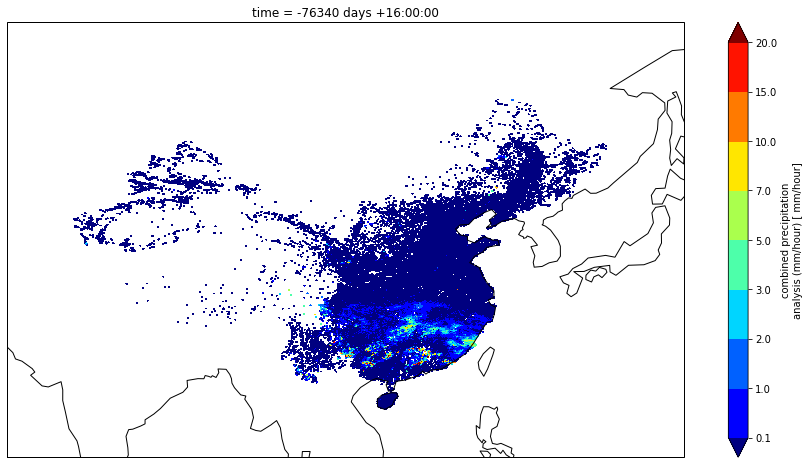

In [65]:
file = "G:\\CMPAS\\DATA_NC\\0P01\\Z_SURF_C_BABJ_20170617044407_P_CMPA_NRT_CHN_0P01_HOR-PRE-2017061513.rain.nc"
ds = xr.open_dataset(file)

plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ds.rain.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.cm.jet, levels=[0.1, 1, 2, 3, 5, 7, 10, 15, 20])
ax.coastlines()

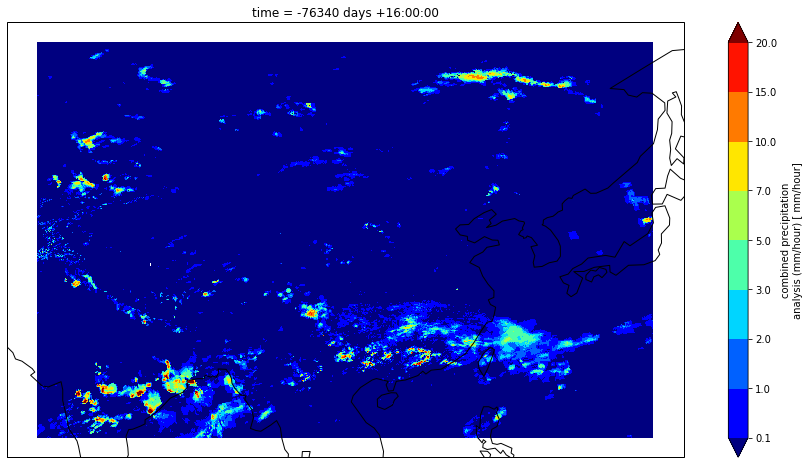

In [66]:
file = "G:\\CMPAS\\DATA_NC\\0P01\\Z_SURF_C_BABJ_20170724155910_P_CMPA_NRT_CHN_0P01_HOR-PRE-2017061513.rain.nc"
ds = xr.open_dataset(file)

plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ds.rain.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.cm.jet, levels=[0.1, 1, 2, 3, 5, 7, 10, 15, 20])
ax.coastlines()